MLP con Early Stopping y Dropout (Core)
Descripción:

En esta actividad, implementarás una red MLP más avanzada, utilizando técnicas como dropout y early stopping para evitar el sobreajuste. El dataset seleccionado es el «Heart Disease UCI» de Kaggle, donde se intentará predecir si un paciente tiene una enfermedad cardíaca o no basándose en varias características.

Enlace al dataset: https://www.kaggle.com/ronitf/heart-disease-uci



Objetivo:

El objetivo de esta actividad es entrenar una red MLP utilizando dropout para regularizar la red y early stopping para detener el entrenamiento cuando el rendimiento en el conjunto de validación deje de mejorar. Al final, se comparará el rendimiento de este modelo con el de un MLP básico.



Instrucciones:



1. Carga de datos:
  - Descarga el dataset «Heart Disease UCI» de Kaggle. Explora las características que están relacionadas con la edad, el sexo, la presión arterial y otras variables clínicas.
  - Verifica si hay valores nulos en el dataset y realiza el preprocesamiento necesario, como la imputación de valores faltantes y la normalización de las variables numéricas.


In [8]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('../data/heart_disease_uci.csv')
# Verificar valores nulos
print(df.info())
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB
None
id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs         

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


**Column Descriptions:**
- id (Unique id for each patient)
- age (Age of the patient in years)
- origin (place of study)
- sex (Male/Female)
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl)
- fbs (if fasting blood sugar > 120 mg/dl)
- restecg (resting electrocardiographic results)
- -- Values: [normal, stt abnormality, lv hypertrophy]
- thalach: maximum heart rate achieved
- exang: exercise-induced angina (True/ False)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
- ca: number of major vessels (0-3) colored by fluoroscopy
- thal: [normal; fixed defect; reversible defect]
- num: the predicted attribute

In [10]:
# Eliminar columnas innecesarias
df.drop("id", axis=1, inplace=True)

# Manejo de valores faltantes
# Vamos a eliminar las columnas ca y thal debido a la gran cantidad de valores faltantes.
df.drop(["ca", "thal"], axis=1, inplace=True)

# Para las columnas restantes con valores faltantes, imputaremos los valores usando la mediana para las variables numéricas y la moda para las variables categóricas.
from sklearn.impute import SimpleImputer

# Imputar valores faltantes en columnas numéricas
numeric_cols = ["trestbps", "chol", "thalch", "oldpeak"]
numeric_imputer = SimpleImputer(strategy="median")
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

# Imputar valores faltantes en columnas categóricas
categorical_cols = ["fbs", "restecg", "exang", "slope"]
categorical_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

In [11]:
# Codificación de variables categóricas
df = pd.get_dummies(df, columns=["sex", "dataset", "cp", "fbs", "restecg", "exang", "slope"], drop_first=True)

# Normalización de variables numéricas
from sklearn.preprocessing import StandardScaler

# Separar características (X) y etiquetas (y)
X = df.drop("num", axis=1)
y = df["num"]

# Normalizar las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


2. Exploración y preprocesamiento de datos:
  - Realiza una división del dataset en conjunto de entrenamiento y prueba. Asegúrate de que el dataset esté bien balanceado, verificando la distribución de la variable objetivo (enfermedad cardíaca sí/no).


In [12]:
from sklearn.model_selection import train_test_split

# Dividir el dataset en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convertir las etiquetas a binario (0 y 1)
# Convertir a problema binario (0 = no enfermedad, 1 = enfermedad)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)


3. Implementación de la MLP con Dropout:
  - Implementa una red MLP con dos capas ocultas utilizando Keras o cualquier biblioteca de deep learning.
  - Agrega capas de dropout después de cada capa oculta para reducir el riesgo de sobreajuste. Utiliza una tasa de dropout del 20-30%.
  - Implementa el early stopping para detener el entrenamiento cuando la precisión en el conjunto de validación deje de mejorar después de varias épocas (por ejemplo, paciencia de 5 épocas).


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Definir el modelo
model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))  # 64 neuronas, activación ReLU
model.add(Dropout(0.2))  # Dropout del 20% para regularización

# Segunda capa oculta
model.add(Dense(32, activation="relu"))  # 32 neuronas, activación ReLU
model.add(Dropout(0.2))  # Dropout del 20%

# Capa de salida (para clasificación binaria)
model.add(Dense(1, activation="sigmoid"))  # 1 neurona, activación Sigmoid

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Resumen del modelo
model.summary()

# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitorear la pérdida en el conjunto de validación
    patience=5,         # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los mejores pesos encontrados
)

c:\Users\diego\miniconda3\envs\deep_learning\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)


4. Entrenamiento del modelo:
  - Entrena el modelo con early stopping activado, utilizando el optimizador Adam y la función de pérdida binaria (binary_crossentropy). Entrena durante un máximo de 100 épocas.
  - Visualiza las curvas de aprendizaje para observar cómo evoluciona la pérdida y la precisión a lo largo del entrenamiento, especialmente con early stopping activado.


In [14]:
# Ahora entrenamos el modelo usando el conjunto de entrenamiento y validación.
history = model.fit(
    X_train, y_train_binary,
    validation_split=0.2,  # Usar 20% de los datos de entrenamiento como validación
    epochs=100,            # Número máximo de épocas
    batch_size=32,         # Tamaño del lote
    callbacks=[early_stopping],  # Aplicar Early Stopping
    verbose=1
)


Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5797 - loss: 0.6864 - val_accuracy: 0.7635 - val_loss: 0.5520
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7389 - loss: 0.5546 - val_accuracy: 0.7905 - val_loss: 0.4841
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8013 - loss: 0.4832 - val_accuracy: 0.7973 - val_loss: 0.4474
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7683 - loss: 0.4840 - val_accuracy: 0.8176 - val_loss: 0.4231
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8045 - loss: 0.4488 - val_accuracy: 0.8243 - val_loss: 0.4017
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8005 - loss: 0.4365 - val_accuracy: 0.8243 - val_loss: 0.3914
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8016 - loss: 0.4254 - val_accuracy: 0.8311 - val_loss: 0.3857
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8375 - loss: 0.3702 - val_accuracy: 0.8378 - 

Pérdida en el conjunto de prueba: 0.3790
Precisión en el conjunto de prueba: 0.8207


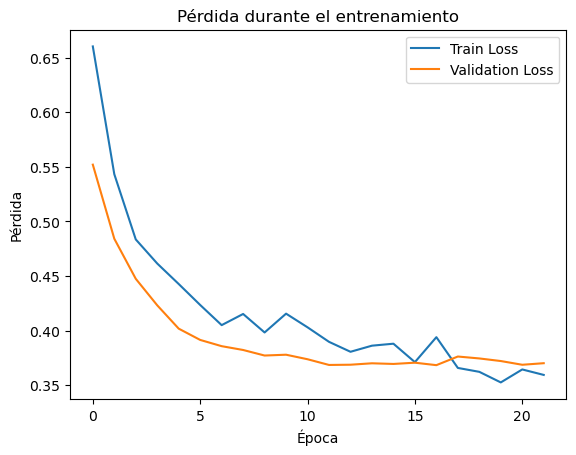

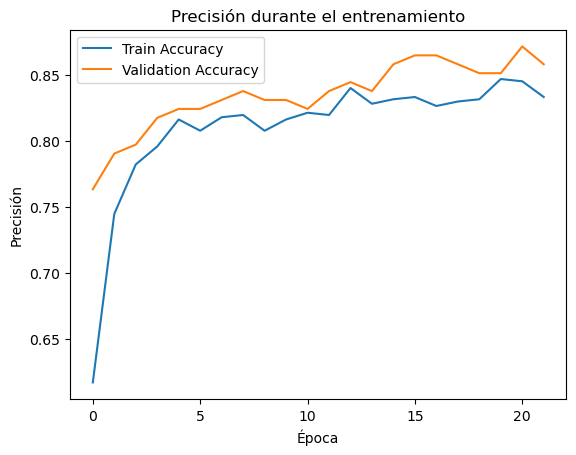

In [15]:

#  Evaluamos el modelo en el conjunto de prueba.
loss, accuracy = model.evaluate(X_test, y_test_binary, verbose=0)
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Precisión durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.legend()
plt.show()


5. Evaluación del modelo:
  - Evalúa el modelo en el conjunto de prueba y compara las métricas de rendimiento, como precisión, recall, F1-score y matriz de confusión.
  - Discute cómo el uso de dropout y early stopping ha afectado el rendimiento en comparación con un MLP básico sin estas técnicas.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Usamos el modelo entrenado para hacer predicciones en el conjunto de prueba.
y_pred_prob = model.predict(X_test)  # Predicciones en probabilidades
y_pred = (y_pred_prob > 0.5).astype(int)  # Convertir probabilidades a clases (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
conf_matrix = confusion_matrix(y_test_binary, y_pred)

# Mostrar métricas
print(f"Precisión: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("Matriz de confusión:")
print(conf_matrix)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Precisión: 0.8207
Recall: 0.8440
F1-score: 0.8479
Matriz de confusión:
[[59 16]
 [17 92]]
